In [1]:
import os
import csv

# 폴더 경로 설정
accident_folders = [
    (r"C:\Users\ime203\Desktop\classfication_data\Car-to-Car", 1),
    (r"C:\Users\ime203\Desktop\classfication_data\Car-to-motorcycle", 2),
    (r"C:\Users\ime203\Desktop\classfication_data\Car-to-bicycle", 2),
    (r"C:\Users\ime203\Desktop\classfication_data\Car-to-Human", 3),
    (r"C:\Users\ime203\Desktop\classfication_data\No Accident", 0)
]

# CSV 파일 생성
csv_file = 'image_labels.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path', 'label'])
    
    for folder, label in accident_folders:
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            writer.writerow([img_path, label])


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


# Dataset class definition
class AccidentDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

# Preprocessing and data augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CSV file path
csv_file = r"C:\Users\ime203\Downloads\yolov8n\image_labels.csv"

# Load dataset
dataset = AccidentDataset(csv_file, transform=transform)

# Split dataset into training and validation sets
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)



Epoch 1/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [39:58<00:00,  6.41s/it]


Epoch [1/5], Loss: 1.0137, Train Accuracy: 0.5864


Epoch 1/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [05:54<00:00,  3.78s/it]


Epoch [1/5], Validation Loss: 0.9272, Validation Accuracy: 0.6477


Epoch 2/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [40:04<00:00,  6.43s/it]


Epoch [2/5], Loss: 0.8284, Train Accuracy: 0.7052


Epoch 2/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [07:23<00:00,  4.72s/it]


Epoch [2/5], Validation Loss: 0.7989, Validation Accuracy: 0.7039


Epoch 3/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [41:07<00:00,  6.60s/it]


Epoch [3/5], Loss: 0.7327, Train Accuracy: 0.7454


Epoch 3/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [06:14<00:00,  3.98s/it]


Epoch [3/5], Validation Loss: 0.7400, Validation Accuracy: 0.7477


Epoch 4/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [30:52<00:00,  4.95s/it]


Epoch [4/5], Loss: 0.6798, Train Accuracy: 0.7670


Epoch 4/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [05:03<00:00,  3.23s/it]


Epoch [4/5], Validation Loss: 0.6576, Validation Accuracy: 0.7715


Epoch 5/5 - Training: 100%|██████████████████████████████████████████████████████████| 374/374 [29:10<00:00,  4.68s/it]


Epoch [5/5], Loss: 0.6442, Train Accuracy: 0.7817


Epoch 5/5 - Validation: 100%|██████████████████████████████████████████████████████████| 94/94 [04:54<00:00,  3.13s/it]


Epoch [5/5], Validation Loss: 0.6293, Validation Accuracy: 0.7819


Final Validation: 100%|████████████████████████████████████████████████████████████████| 94/94 [04:28<00:00,  2.86s/it]


Final Validation Accuracy: 0.7818668450986952
Final Precision: 0.7792769771416872
Final Recall: 0.7818668450986952
Final F1 Score: 0.776253879127938


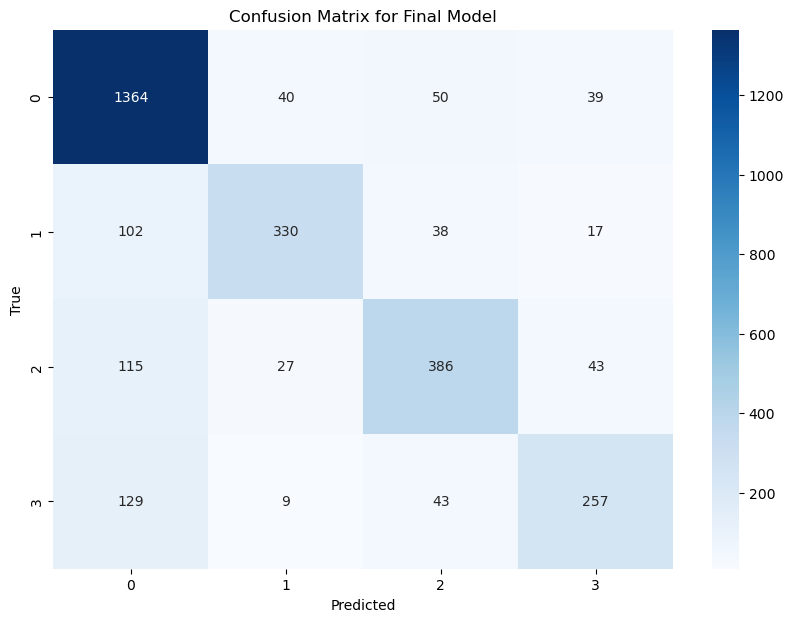

In [8]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm

# Googlenet+LSTM model definition
class GooglenetLSTMClassifier(nn.Module):
    def __init__(self, num_classes, hidden_dim=128, lstm_layers=2, lstm_dropout=0.5):
        super(GooglenetLSTMClassifier, self).__init__()
        self.cnn = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        num_ftrs = self.cnn.fc.in_features
        self.cnn.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, hidden_dim)
        )
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, lstm_layers, batch_first=True, dropout=lstm_dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if len(x.shape) == 5:
            batch_size, seq_length, c, h, w = x.size()
            cnn_out = []
            for t in range(seq_length):
                cnn_out.append(self.cnn(x[:, t, :, :, :]))

            cnn_out = torch.stack(cnn_out, dim=1)
            lstm_out, _ = self.lstm(cnn_out)
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        elif len(x.shape) == 4:
            cnn_out = self.cnn(x)
            lstm_out, _ = self.lstm(cnn_out.unsqueeze(1))
            lstm_out = lstm_out[:, -1, :]
            out = self.fc(lstm_out)
        else:
            raise ValueError("Unsupported input shape")

        return out


# Initialize the Googlenet+LSTM model
num_classes = 4
googlenet_lstm_model = GooglenetLSTMClassifier(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet_lstm_model.parameters(), lr=0.001)

# Training and validation code (similar to the code provided in the original snippet)


# Training the CNN+LSTM model
num_epochs = 5
for epoch in range(num_epochs):
    googlenet_lstm_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        optimizer.zero_grad()
        outputs = googlenet_lstm_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")


    # Validation
    googlenet_lstm_model.eval()
    val_running_loss = 0.0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation"):
            outputs = googlenet_lstm_model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.numpy())
            val_labels.extend(labels.numpy())

    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_loss = val_running_loss / len(val_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Final evaluation
googlenet_lstm_model.eval()
val_predictions = []
val_labels = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Validation"):
        outputs = googlenet_lstm_model(images)
        _, predicted = torch.max(outputs, 1)
        val_predictions.extend(predicted.numpy())
        val_labels.extend(labels.numpy())

# Evaluate the final model
val_accuracy = accuracy_score(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)
prec = precision_score(val_labels, val_predictions, average='weighted')
rec = recall_score(val_labels, val_predictions, average='weighted')
f1 = f1_score(val_labels, val_predictions, average='weighted')

print(f'Final Validation Accuracy: {val_accuracy}')
print(f'Final Precision: {prec}')
print(f'Final Recall: {rec}')
print(f'Final F1 Score: {f1}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Final Model')
plt.show()
